## Deepfake classification

The video frames are classified using Inception Net in Keras. A confusion matrix is plotted to visualize the results on the test set.

In [1]:
# Import packages.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from tensorflow import keras as K
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Check if GPU is available.
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
tf.config.list_physical_devices('GPU')

In [2]:
# Initialize Inception Net V3 pretrained on ImageNet.
inception_model = K.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(200, 200, 3),
    include_top=False)

In [3]:
# Use transfer learning, set base model to untrainable.
inception_model.trainable=False

In [4]:
# Add MaxPooling layer and binary classification linear layer.
x = inception_model.output
x = K.layers.GlobalMaxPooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inception_model.input, outputs=predictions)

In [5]:
# Compile model.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Generate dataloaders.
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        'D:/data/facefor/FaceForensics_compressed/train200',  # this is the target directory  
        batch_size=16,
        class_mode='binary',
    shuffle=True)

val_generator = test_datagen.flow_from_directory(
        'D:/data/facefor/FaceForensics_compressed/val200',  # this is the target directory  
        batch_size=16,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'D:/data/facefor/FaceForensics_compressed/test200',  # this is the target directory  
        batch_size=16,
        class_mode='binary',
shuffle=False)

Found 66762 images belonging to 2 classes.


In [ ]:
# Fit the model.
model.fit(x=train_generator, 
    epochs=15,
    verbose=1,
    shuffle=True,
    validation_data = val_generator
)
model.save_weights('ffinception2.h5') 

In [14]:
# Evaluate the model on the test set.
model.evaluate(
    x=test_generator,
    verbose=1,
)

  ...
    to  
  ['...']
4899/4899 [==============================] - 395s 81ms/step - loss: -5.1543 - accuracy: 0.6958


[-5.154281998279431, 0.6958114]

In [86]:
# Make prediction on the test set.
preds = model.predict(
    x=test_generator,
    verbose=1,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

980/980 [==============================] - 63s 64ms/step


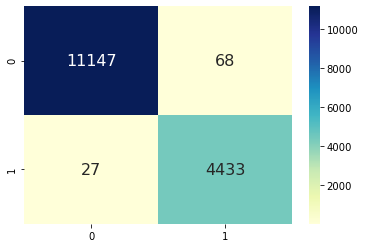

In [92]:
# Generate aand display confusion matrix.
cm = confusion_matrix(test_generator.classes, preds)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, cmap="YlGnBu",fmt="g", annot_kws={"size": 16}) # font size

plt.show()

In [93]:
# Print precision, recall and f1 score.
print(classification_report(test_generator.classes, preds)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     11215
           1       0.98      0.99      0.99      4460

    accuracy                           0.99     15675
   macro avg       0.99      0.99      0.99     15675
weighted avg       0.99      0.99      0.99     15675



In [ ]:
# GradCam implementation is based on paper Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
def heatmap(dirname):
    count = 0
    for img in glob.glob(f"{dirname}/*.jpg"):
        face_org = cv2.imread(img)
        face_res = cv2.resize(face_org, (200,200))
        img = image.load_img(img, target_size=(200, 200))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x=x,
        verbose=1,
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
        )
        crop_output = model.output[:, 0]

        last_conv_layer = model.get_layer('block14_sepconv1')

        grads = K.backend.gradients(crop_output, last_conv_layer.output)[0]
    
        pooled_grads = K.backend.mean(grads, axis=(0, 1, 2))

        iterate = K.backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])

        pooled_grads_value, conv_layer_output_value = iterate([x])

        for i in range(512):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
  
        img = face_org

        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        heatmap = np.uint8(255 * heatmap)

        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        superimposed_img = heatmap * 0.4 + img
        
# Replace path with path to folder where to store the overlay images
        cv2.imwrite('WRITE PATH/%imposed.jpg' % count, superimposed_img)
        count += 1

In [ ]:
# Replace path with the path to source folder
heatmap('SOURCE PATH')